In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import glob
import os
import unicodedata
import string
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init

# 定义一个函数，用于查找与指定路径模式匹配的文件
def findFiles(path): 
    return glob.glob(path)

# 定义所有可能字符
all_letters = string.ascii_letters + " .,;'"
# 计算字符总数
n_letters = len(all_letters)

# 函数将Unicode字符串转换为ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 初始化一个字典，用于保存每个类别的行
category_lines = {}
# 初始化一个列表，用于保存所有类别的名称
all_categories = []

# 从文件中读取行并将其规范化为ASCII
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 遍历每个与指定模式匹配的文件
for filename in findFiles('data/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

# 根据all_letters中字母的顺序找到字母的索引，例如："a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)
# 仅用于演示，将字母转换为<1 x n_letters>的张量
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 将一行转换为<line_length x 1 x n_letters>的张量，
# 或者是一个由单热编码字母向量组成的数组
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
# 创建自定义数据集类
class NamesDataset(Dataset):
    def __init__(self, category_lines, all_categories, all_letters):
        self.category_lines = category_lines
        self.all_categories = all_categories
        self.all_letters = all_letters
        self.n_categories = len(all_categories)

        self.data = []
        for category in all_categories:
            for line in category_lines[category]:
                category_idx = all_categories.index(category)
                line_tensor = self.lineToTensor(line)
                self.data.append((category_idx, line_tensor))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        category_idx, line_tensor = self.data[idx]
        return category_idx, line_tensor

    def letterToIndex(self, letter):
        return self.all_letters.find(letter)

    def lineToTensor(self, line):
        tensor = torch.zeros(len(line), len(self.all_letters))
        for li, letter in enumerate(line):
            tensor[li][self.letterToIndex(letter)] = 1
        return tensor

# 初始化数据集
dataset = NamesDataset(category_lines, all_categories, all_letters)

# 将数据集拆分为训练集和测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
def collate_fn(batch):
    # 获取类别张量和行张量
    category_tensors, line_tensors = zip(*batch)
    
    # 将类别转换为张量
    category_tensors = torch.tensor(category_tensors, dtype=torch.long)
    
    # 获取每个序列的长度
    lengths = [tensor.size(0) for tensor in line_tensors]
    max_length = max(lengths)
    
    # 创建填充后的张量
    padded_tensors = torch.zeros(len(line_tensors), max_length, n_letters)
    for i, tensor in enumerate(line_tensors):
        end = lengths[i]
        padded_tensors[i, :end, :] = tensor
    
    return category_tensors, padded_tensors


# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)





In [40]:


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        # 初始化线性层的权重参数
        init.xavier_uniform_(self.i2o.weight)
        
    def forward(self, input, hidden):
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.i2o(output.view(1, -1))
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # 初始化隐藏状态和细胞状态
        return torch.zeros(1, 1, self.hidden_size),torch.zeros(1, 1, self.hidden_size)
n_categories = len(all_categories)
n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)
print(lstm)
device=torch.device("cpu")
lstm.to(device)


LSTM(
  (lstm): LSTM(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


LSTM(
  (lstm): LSTM(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [41]:
import torch.nn.functional as F
criterion = nn.NLLLoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.005)
def train(category_tensor, line_tensor):
    lstm.train()
    hidden, cell = lstm.initHidden()
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    lstm.zero_grad()
    
    # 注意 line_tensor 的维度应该是 [batch_size, seq_len, input_size]
    # 我们需要将其转换为 [seq_len, batch_size, input_size] 以符合 LSTM 的输入
    line_tensor = line_tensor.permute(1, 0, 2)
    
    for i in range(line_tensor.size(0)):
        output, (hidden, cell) = lstm(line_tensor[i], (hidden, cell))
    
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()


# 评估函数
def evaluate(line_tensor):
    lstm.eval()
    hidden,cell = lstm.initHidden()
    line_tensor = line_tensor.permute(1, 0, 2)
    
    for i in range(line_tensor.size(0)):
        output, (hidden, cell)= lstm(line_tensor[i], (hidden,cell))
    
    return output

Epoch 1/30, Loss: 1.6486, Accuracy: 0.5699
Epoch 2/30, Loss: 1.3600, Accuracy: 0.6286
Epoch 3/30, Loss: 1.1963, Accuracy: 0.6513
Epoch 4/30, Loss: 1.0756, Accuracy: 0.7009
Epoch 5/30, Loss: 0.9988, Accuracy: 0.7068
Epoch 6/30, Loss: 0.9464, Accuracy: 0.7218
Epoch 7/30, Loss: 0.9009, Accuracy: 0.7248
Epoch 8/30, Loss: 0.8668, Accuracy: 0.7233
Epoch 9/30, Loss: 0.8357, Accuracy: 0.7562
Epoch 10/30, Loss: 0.8086, Accuracy: 0.7562
Epoch 11/30, Loss: 0.7817, Accuracy: 0.7539
Epoch 12/30, Loss: 0.7578, Accuracy: 0.7709
Epoch 13/30, Loss: 0.7322, Accuracy: 0.7763
Epoch 14/30, Loss: 0.7088, Accuracy: 0.7791
Epoch 15/30, Loss: 0.6867, Accuracy: 0.7883
Epoch 16/30, Loss: 0.6616, Accuracy: 0.7808
Epoch 17/30, Loss: 0.6425, Accuracy: 0.7913
Epoch 18/30, Loss: 0.6239, Accuracy: 0.7903
Epoch 19/30, Loss: 0.6055, Accuracy: 0.7918
Epoch 20/30, Loss: 0.5860, Accuracy: 0.7928
Epoch 21/30, Loss: 0.5718, Accuracy: 0.7910
Epoch 22/30, Loss: 0.5542, Accuracy: 0.7945
Epoch 23/30, Loss: 0.5383, Accuracy: 0.80

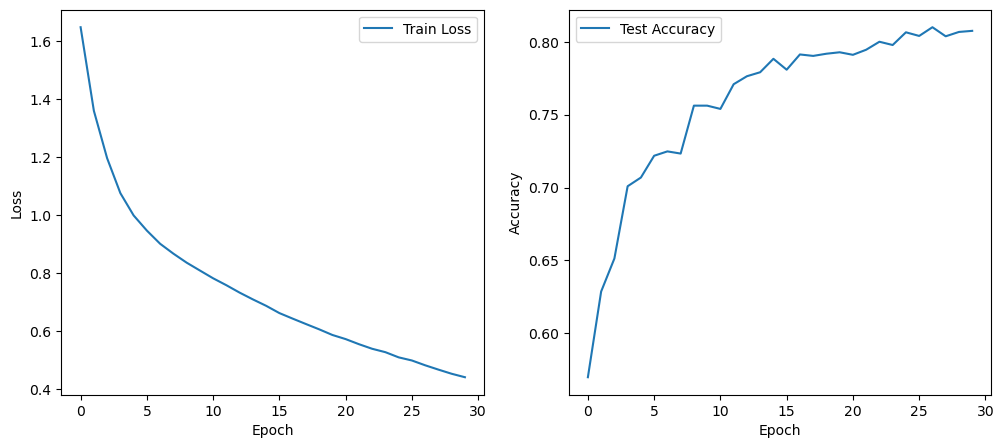

In [42]:
def train_and_evaluate(num_epochs):
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        for category_tensor, line_tensor in train_loader:
            category_tensor = category_tensor.to(torch.long)
            output, loss = train(category_tensor, line_tensor)
            total_loss += loss
        
        train_losses.append(total_loss / len(train_loader))
        
        correct = 0
        total = 0
        with torch.no_grad():
            for category_tensor, line_tensor in test_loader:
                output = evaluate(line_tensor)
                _, predicted = torch.max(output, 1)
                total += category_tensor.size(0)
                correct += (predicted == category_tensor).sum().item()
        
        test_accuracies.append(correct / total)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {correct / total:.4f}')
    
    return train_losses, test_accuracies

# 开始训练并绘制曲线
num_epochs = 30
train_losses, test_accuracies = train_and_evaluate(num_epochs)

# 绘制训练损失曲线和验证准确度曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

C:\Users\苏集源\AppData\Local\Temp\ipykernel_14808\1505734569.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\苏集源\AppData\Local\Temp\ipykernel_14808\1505734569.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


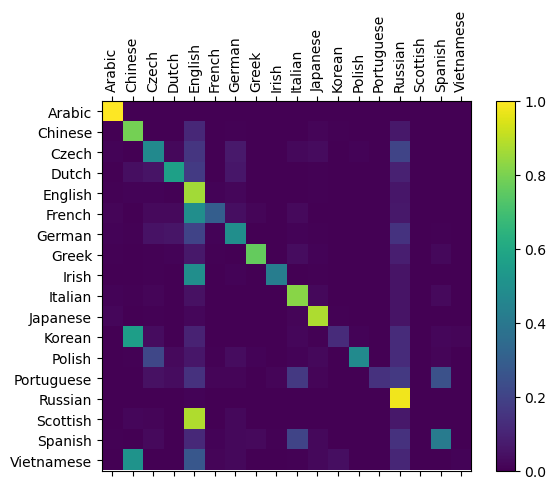

In [43]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
import matplotlib.ticker as ticker
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
def evaluate(line_tensor):
    lstm.eval()
    hidden, cell = lstm.initHidden()
    output = None
    
    for i in range(line_tensor.size(0)):
        input_tensor = line_tensor[i].unsqueeze(0).unsqueeze(0)  # 增加 batch_size 和 seq_len 维度
        output, (hidden, cell) = lstm(input_tensor, (hidden, cell))
    
    return output


# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    _, guess_i = torch.max(output, 1)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()